# Are Stock Prices Random Walks? 
A volatility ratio check

## Importing relevant packagess

In [1]:
# Importing Basic Libs
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import statistics
import math 
import scipy.stats

#Yahoo Finance
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 110 kB 29.0 MB/s 
     |████████████████████████████████| 112 kB 54.5 MB/s 
     |████████████████████████████████| 4.1 MB 56.5 MB/s 
     |████████████████████████████████| 128 kB 58.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


#Creating Variance Ratio Test Functions

## Calculating returns based on k_day intervals

In [3]:
#Function to return k_day_returns
def k_day_returns(df,n): 
  string1 = '_day_returns'
  string2 = str(n)
  col_name = string2 + string1
  df[col_name] = df['Close'].pct_change(periods = int(n) , fill_method='ffill')
  return df

In [5]:
# Function for adding k_days to df
def get_k_day_returns(df, period_array):

  for period in period_array: 
    df = k_day_returns(df,period)

  returns = df.copy() 
  returns.drop(returns.iloc[:, 0:7], inplace=True, axis=1)
  return returns

## Extracting variance ratios and conducting significance test

In [10]:
#Calculating Variance Ratios 
def get_varRat(n_observations, period_array, returns):
  #Intializing vectors
  var_price = [] 
  var_ratio = []
  #Calculating base variance
  s1 = statistics.variance(returns['1_day_returns'].dropna())
  
  #Variance
  for columns in returns: 
      s = statistics.variance(returns[columns].dropna())
      var_price.append(s)
  #Variance Ratio
  for i in range(0,len(period_array)):
      t = ( var_price[i]/(period_array[i]*s1) ) - 1 
      var_ratio.append(t)

  #Putting data into dataframe
  df = pd.DataFrame({'period':period_array, 'var_price':var_price, 'var_ratio': var_ratio})   

  # Calculating Variance & Standard Deviation of the Variance-Ratio
  df['var_VarRat'] = ( (2*(df['period']-1)) * (2*df['period'] - 1) )/ (3*df['period']*n_observations)
  # Calculating Std Deviation for the Variance-Ratio 
  df['std_VarRat']= np.sqrt( df['var_VarRat'] )
  #Calculating z-score 
  df['z_score'] = df['var_ratio']/df['std_VarRat']
  #Calculating p-value 
  df['p_val'] = 1 - scipy.stats.norm.sf(abs(df['z_score']))

  return df

# Conducting test on S&P 500 data

In [2]:
#Download SPX data 
index = yf.Ticker("^GSPC")

# get prices 
df = index.history(period="max")

#Viewinf the prices
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [13]:
period_array = [1,2,4,8,6,16,32,64,128,256, 512,1024,2048]
returns = get_k_day_returns(df,period_array)
var_rat = get_varRat(df.shape[0], period_array, returns)
print(var_rat)

    period  var_price  var_ratio  var_VarRat  std_VarRat   z_score     p_val
0        1   0.000144   0.000000    0.000000    0.000000       NaN       NaN
1        2   0.000284  -0.014911    0.000042    0.006473 -2.303539  0.989376
2        4   0.000553  -0.040259    0.000147    0.012110 -3.324349  0.999557
3        8   0.001080  -0.062127    0.000367    0.019148 -3.244555  0.999412
4        6   0.000822  -0.048197    0.000256    0.016002 -3.011897  0.998702
5       16   0.002229  -0.032359    0.000812    0.028493 -1.135675  0.871954
6       32   0.004706   0.021312    0.001705    0.041290  0.516146  0.697124
7       64   0.009563   0.037737    0.003492    0.059096  0.638568  0.738448
8      128   0.018080  -0.019025    0.007068    0.084070 -0.226301  0.589516
9      256   0.041483   0.125369    0.014219    0.119243  1.051374  0.853457
10     512   0.078447   0.064077    0.028522    0.168883  0.379418  0.647811
11    1024   0.194393   0.318407    0.057127    0.239012  1.332179  0.908599

## Visualizing Results

It is evident that prices are random walks across observations periods. 

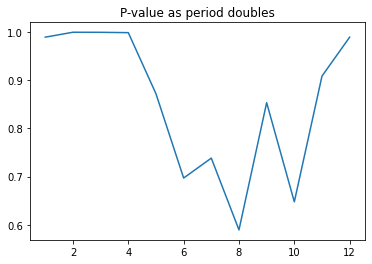

In [17]:
#Visualizing the Data
plt.plot(var_rat['p_val'])
plt.title('P-value as period doubles')
plt.show()

In [28]:
import datetime
# Test # 2 

#Date constrainted 
startDate = datetime.datetime(2015, 1, 1)
endDate = startDate + datetime.timedelta(days=1258)

# get prices 
df = index.history(start = startDate, end = endDate)

#Viewinf the prices
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,2058.899902,2072.360107,2046.040039,2058.199951,2708700000,0.0,0.0
2015-01-05 00:00:00-05:00,2054.439941,2054.439941,2017.339966,2020.579956,3799120000,0.0,0.0
2015-01-06 00:00:00-05:00,2022.150024,2030.250000,1992.439941,2002.609985,4460110000,0.0,0.0
2015-01-07 00:00:00-05:00,2005.550049,2029.609985,2005.550049,2025.900024,3805480000,0.0,0.0
2015-01-08 00:00:00-05:00,2030.609985,2064.080078,2030.609985,2062.139893,3934010000,0.0,0.0


In [29]:
period_array = [1,2,4,8,16]
returns = get_k_day_returns(df,period_array)
print(returns)
var_rat = get_varRat(df.shape[0], period_array, returns)
print(var_rat)

                           1_day_returns  2_day_returns  4_day_returns  \
Date                                                                     
2015-01-02 00:00:00-05:00            NaN            NaN            NaN   
2015-01-05 00:00:00-05:00      -0.018278            NaN            NaN   
2015-01-06 00:00:00-05:00      -0.008893      -0.027009            NaN   
2015-01-07 00:00:00-05:00       0.011630       0.002633            NaN   
2015-01-08 00:00:00-05:00       0.017888       0.029726       0.001914   
...                                  ...            ...            ...   
2018-06-05 00:00:00-04:00       0.000703       0.005185       0.009101   
2018-06-06 00:00:00-04:00       0.008567       0.009276       0.024796   
2018-06-07 00:00:00-04:00      -0.000714       0.007847       0.013073   
2018-06-08 00:00:00-04:00       0.003126       0.002409       0.011708   
2018-06-11 00:00:00-04:00       0.001069       0.004198       0.012078   

                           8_day_retu